In [1]:
from MuonSimulationHelpers import *
from matplotlib.pyplot import cm
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.style.use('figures.mplstyle')


def crossing_muon_rates(simulation):
    mu_weights = np.array(simulation.data['muon_weights'])
    mu_detector_distances = np.array(simulation.data['muon_lengths'])
    mu_surface_distances = np.array(simulation.data['lepton_surface_distances'])
    mu_distances = np.array([min(x,y) for x,y in zip(mu_detector_distances,mu_surface_distances)])
    mu_profile = np.array([simulation.data['muon_transverse_profile_x'],
                           simulation.data['muon_transverse_profile_y']]).T
    
    def Xf(E,rho=1):
        return 1./(rho * 5e-4) * np.log(1 + 2e-3 * E)
    
    mu_ranges = Xf(simulation.data["E_lep"],rho=2.7)
    mu_weights *= mu_distances<mu_ranges
    mu_radius = np.sqrt(np.sum(mu_profile**2,axis=-1))
    fid_weights = {}
    for rad_cut in [5,10,15]:
        fid_weights[rad_cut] = (mu_weights * (mu_radius<rad_cut))
    return fid_weights

def fiducial_int_rates(simulation,length_cut=500):
    nu_weights = np.array(simulation.data['nu_weight']*simulation.data['interaction_probability'])
    beamline_dist = np.array(simulation.data['DIS_distance']*simulation.data['uz'])
    nu_profile = np.array([simulation.data['DIS_distance']*simulation.data['ux'],
                           simulation.data['DIS_distance']*simulation.data['uy']]).T
    nu_radius = np.sqrt(np.sum(nu_profile**2,axis=-1))
    nu_weights *= (np.logical_and(beamline_dist<(10000+length_cut/2),
                                  beamline_dist>(10000-length_cut/2)))
    fid_weights = {}
    for rad_cut in [2,5,10]:
        fid_weights[rad_cut] = (nu_weights * (nu_radius<rad_cut))
    return fid_weights
    
    
    
    


In [2]:
def total_weights(light_simulation,charm_simulation,mode):
    if mode=="surface":
        fid_weights_l = crossing_muon_rates(light_simulation)
        fid_weights_c = crossing_muon_rates(charm_simulation)
    elif mode=="lake":
        fid_weights_l = fiducial_int_rates(light_simulation)
        fid_weights_c = fiducial_int_rates(charm_simulation)
    return fid_weights_l,fid_weights_c

In [3]:
light_generators = ["EPOSLHC","DPMJET","SIBYLL","QGSJET","PYTHIA8"]
charm_generators = ["BKSS","BKRS","SIBYLL","BDGJKR","MS"]

surface_fid_weights = {}
lake_CC_fid_weights = {}
lake_NC_fid_weights = {}

light_simulation_surface_dict = {}
charm_simulation_surface_dict = {}
light_simulation_lakeCC_dict = {}
charm_simulation_lakeCC_dict = {}
light_simulation_lakeNC_dict = {}
charm_simulation_lakeNC_dict = {}

for gen_l,gen_c in zip(light_generators,charm_generators):
    print(gen_l,gen_c)
    print("lake CC")
    light_simulation_lakeCC_dict[(gen_l,gen_c)] = MuonSimulation('Data/MuonSimulation/LHCb_LHC13_%s_light_lake_CC_10000_100.parquet'%gen_l)
    charm_simulation_lakeCC_dict[(gen_l,gen_c)] = MuonSimulation('Data/MuonSimulation/LHCb_LHC13_%s_charm_lake_CC_10000_100.parquet'%gen_c)
    lake_CC_fid_weights[(gen_l,gen_c)] = total_weights(light_simulation_lakeCC_dict[(gen_l,gen_c)],
                                                       charm_simulation_lakeCC_dict[(gen_l,gen_c)],
                                                       mode="lake")
    print("lake NC")
    light_simulation_lakeNC_dict[(gen_l,gen_c)] = MuonSimulation('Data/MuonSimulation/LHCb_LHC13_%s_light_lake_NC_10000_100.parquet'%gen_l)
    charm_simulation_lakeNC_dict[(gen_l,gen_c)] = MuonSimulation('Data/MuonSimulation/LHCb_LHC13_%s_charm_lake_NC_10000_100.parquet'%gen_c)
    lake_NC_fid_weights[(gen_l,gen_c)] = total_weights(light_simulation_lakeNC_dict[(gen_l,gen_c)],
                                                       charm_simulation_lakeNC_dict[(gen_l,gen_c)],
                                                       mode="lake")
    print("surface")
    light_simulation_surface_dict[(gen_l,gen_c)] = MuonSimulation('Data/MuonSimulation/LHCb_LHC13_%s_light_surface_CC.parquet'%gen_l)
    charm_simulation_surface_dict[(gen_l,gen_c)] = MuonSimulation('Data/MuonSimulation/LHCb_LHC13_%s_charm_surface_CC.parquet'%gen_c)
    surface_fid_weights[(gen_l,gen_c)] = total_weights(light_simulation_surface_dict[(gen_l,gen_c)],
                                                       charm_simulation_surface_dict[(gen_l,gen_c)],
                                                       mode="surface")
    



EPOSLHC BKSS
lake CC
lake NC
surface
DPMJET BKRS
lake CC
lake NC
surface
SIBYLL SIBYLL
lake CC
lake NC
surface
QGSJET BDGJKR
lake CC
lake NC
surface
PYTHIA8 MS
lake CC
lake NC
surface


Detector 0
('EPOSLHC', 'BKSS')
('DPMJET', 'BKRS')
('SIBYLL', 'SIBYLL')
('QGSJET', 'BDGJKR')
('PYTHIA8', 'MS')
Detector 1
('EPOSLHC', 'BKSS')
('DPMJET', 'BKRS')
('SIBYLL', 'SIBYLL')
('QGSJET', 'BDGJKR')
('PYTHIA8', 'MS')
Detector 2
('EPOSLHC', 'BKSS')
('DPMJET', 'BKRS')
('SIBYLL', 'SIBYLL')
('QGSJET', 'BDGJKR')
('PYTHIA8', 'MS')


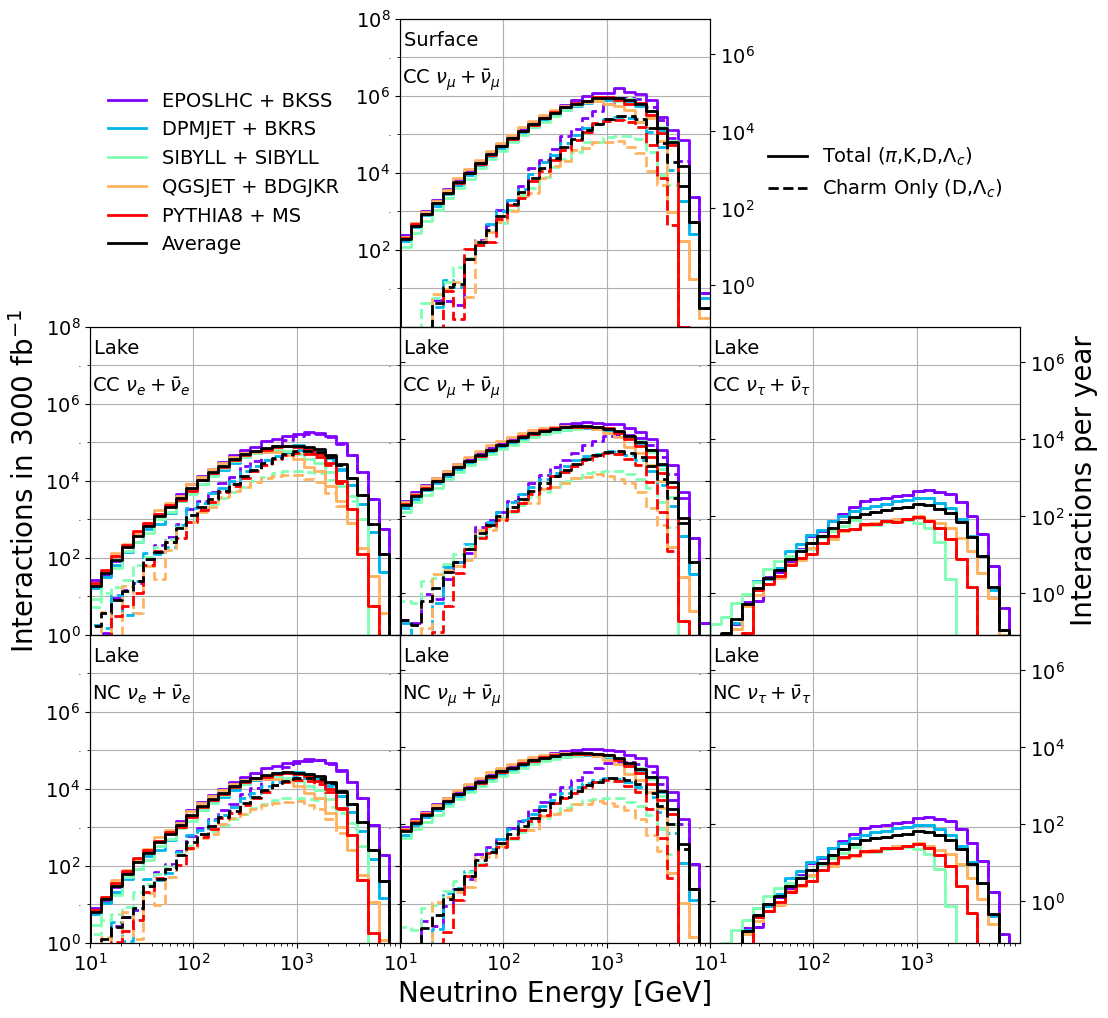

In [6]:
fig,ax = plt.subplots(3,3,figsize=(12,12))
fig.set_facecolor("white")

twin_ax = np.empty_like(ax)
for i in range(3):
    for j in range(3):
        twin_ax[i,j] = ax[i,j].twinx()
        

fig.subplots_adjust(wspace=0, hspace=0)
ax[0,0].axis("off")
ax[0,2].axis("off")
twin_ax[0,0].axis("off")
twin_ax[0,2].axis("off")

Ebins = np.logspace(1,4,30)
pids = [12,14,16]

#color = iter(cm.rainbow(np.linspace(0, 1, 3)))
exposure_factor = 20 # 3 ab^-1 / 150 fb^-1
yearly_factor = 250./3000. # 250 fb^-1 per year / 3 ab^-1 total

total_rates_dict = {}
for gen_l,gen_c in zip(light_generators,charm_generators):
    total_rates_dict[(gen_l,gen_c)] = np.zeros((9,9))

for i,rates in enumerate([surface_fid_weights,lake_CC_fid_weights,lake_NC_fid_weights]):
    print("Detector",i)
    if i==0: kcut = 10
    else: kcut = 5
    color = iter(cm.rainbow(np.linspace(0, 1, len(rates))))
    
    Ehist_l_avg = {pid:np.zeros(len(Ebins)-1) for pid in pids}
    Ehist_c_avg = {pid:np.zeros(len(Ebins)-1) for pid in pids}
    Ehist_avg = {pid:np.zeros(len(Ebins)-1) for pid in pids}
    for k,(fid_weights_l,fid_weights_c) in rates.items():
        print(k)
        c = next(color)
        gen_l,gen_c = k
        if i==0:
            light_simulation = light_simulation_surface_dict[k]
            charm_simulation = charm_simulation_surface_dict[k]
            # light_simulation = MuonSimulation('Data/MuonSimulation/LHCb_LHC13_%s_light_surface_CC.parquet'%gen_l)
            # charm_simulation = MuonSimulation('Data/MuonSimulation/LHCb_LHC13_%s_charm_surface_CC.parquet'%gen_c)
        elif i==1:  
            light_simulation = light_simulation_lakeCC_dict[k]
            charm_simulation = charm_simulation_lakeCC_dict[k]
            # light_simulation = MuonSimulation('Data/MuonSimulation/LHCb_LHC13_%s_light_lake_CC_10000_100.parquet'%gen_l)
            # charm_simulation = MuonSimulation('Data/MuonSimulation/LHCb_LHC13_%s_charm_lake_CC_10000_100.parquet'%gen_c)
        elif i==2:
            light_simulation = light_simulation_lakeNC_dict[k]
            charm_simulation = charm_simulation_lakeNC_dict[k]
            # light_simulation = MuonSimulation('Data/MuonSimulation/LHCb_LHC13_%s_light_lake_NC_10000_100.parquet'%gen_l)
            # charm_simulation = MuonSimulation('Data/MuonSimulation/LHCb_LHC13_%s_charm_lake_NC_10000_100.parquet'%gen_c)

        for iax,pid in enumerate(pids):
            pid_mask_l = abs(light_simulation.data["PDG"])==pid
            pid_mask_c = abs(charm_simulation.data["PDG"])==pid
            Ehist_l,_ = np.histogram(light_simulation.data["E"][pid_mask_l],bins=Ebins,weights=exposure_factor*fid_weights_l[kcut][pid_mask_l])
            Ehist_c,_ = np.histogram(charm_simulation.data["E"][pid_mask_c],bins=Ebins,weights=exposure_factor*fid_weights_c[kcut][pid_mask_c])
            Ehist = Ehist_l+Ehist_c
            Ehist_l_avg[pid] += Ehist_l/len(rates)
            Ehist_c_avg[pid] += Ehist_c/len(rates)
            Ehist_avg[pid] += Ehist/len(rates)
            if not(i==0 and iax!=1):
                ax[i,iax].step(Ebins,np.append([0],Ehist_c),color=c,ls="--")
                ax[i,iax].step(Ebins,np.append([0],Ehist),color=c)
                # twin_ax[i,iax].step(Ebins,yearly_factor*np.append([0],Ehist_c),color=c,ls="--")
                # twin_ax[i,iax].step(Ebins,yearly_factor*np.append([0],Ehist),color=c)
            elif i==0 and iax==0:
                ax[i,iax].plot([],[],label="%s + %s"%(k[0],k[1]),color=c)
            for ik,_kcut in enumerate(fid_weights_l.keys()):
                total_l = sum(exposure_factor*fid_weights_l[_kcut][pid_mask_l])
                total_c = sum(exposure_factor*fid_weights_c[_kcut][pid_mask_c])
                total_rates_dict[k][3*i+ik,iax] = total_l+total_c
                total_rates_dict[k][3*i+ik,iax+3] = total_l
                total_rates_dict[k][3*i+ik,iax+6] = total_c
    for iax,pid in enumerate(pids):
        if not(i==0 and iax!=1):
            ax[i,iax].step(Ebins,np.append([0],Ehist_c_avg[pid]),color="black",ls="--")
            ax[i,iax].step(Ebins,np.append([0],Ehist_avg[pid]),color="black")
            # twin_ax[i,iax].step(Ebins,np.append([0],yearly_factor*Ehist_c_avg[pid]),color="black",ls="--")
            # twin_ax[i,iax].step(Ebins,np.append([0],yearly_factor*Ehist_avg[pid]),color="black")
        elif i==0 and iax==0:
             ax[i,iax].plot([],[],label="Average",color="black")
                
                

ax[2,1].set_xlabel("Neutrino Energy [GeV]",fontsize=20)
ax[1,0].set_ylabel(r"Interactions in $3000~{\rm fb}^{-1}$",fontsize=20)
twin_ax[1,2].set_ylabel(r"Interactions per year",fontsize=20)
ax[0,2].plot([],[],color="black",label=r"Total ($\pi$,K,D,$\Lambda_c$)")
#ax[0,2].plot([],[],color="black",ls='--',label=r"$\pi$,K")
ax[0,2].plot([],[],color="black",ls='--',label=r"Charm Only (D,$\Lambda_c$)")
ax[0,0].legend(loc="center left",fontsize=14)
ax[0,2].legend(loc="center right",fontsize=14)

det_labels = ["Surface CC","Lake CC", "Lake NC"]
particle_labels = [r"$\nu_e+\bar{\nu}_e$",
                   r"$\nu_\mu+\bar{\nu}_\mu$",
                   r"$\nu_\tau+\bar{\nu}_\tau$"]
for i in [0,1,2]:
    for j in [0,1,2]:
            
        ax[i,j].set_xlim(1e1,Ebins[-1])
        ax[i,j].set_ylim(1e0,1e8)
        ax[i,j].set_xlim(1e1,1e4)
        ax[i,j].tick_params(axis='both', which='major', labelsize=14)
        ax[i,j].tick_params(axis='both', which='minor', labelsize=0)
        twin_ax[i,j].tick_params(axis='both', which='major', labelsize=14)
        ax[i,j].get_xaxis().grid(True,which='major')
        ax[i,j].get_yaxis().grid(True,which='both')
        
        if not(i==0 and j in [0,2]):
            ax[i,j].text(11,2e7,det_labels[i][:-2],fontsize=14)
            ax[i,j].text(10.5,2e6,det_labels[i][-2:]+" "+ particle_labels[j],fontsize=14)
            ax[i,j].loglog()
            mn, mx = ax[i,j].get_ylim()
            twin_ax[i,j].set_ylim(mn*yearly_factor, mx*yearly_factor)
            twin_ax[i,j].loglog()
        
        # xticks
        if i!=2: 
            ax[i,j].set_xticklabels([])
        if i!= 0: 
            ax[i,j].set_xticks(np.logspace(1,3,3))
        
        # yticks
        if i==0 and j==1:
            ax[i,j].set_yticks(np.logspace(2,8,4))
            ax[i,j].set_yticks(np.logspace(1,8,8),minor=True)
        elif i==1 and j==0:
            ax[i,j].set_yticks(np.logspace(0,8,5))
            ax[i,j].set_yticks(np.logspace(0,8,9),minor=True)
        elif i==2 and j==0:
            ax[i,j].set_yticks(np.logspace(0,6,4))
            ax[i,j].set_yticks(np.logspace(0,7,8),minor=True)
        else:
            ax[i,j].set_yticks(np.logspace(0,8,9),minor=True)
            ax[i,j].set_yticklabels([])
        
        if (i==0 and j==1) or (j==2 and i in [1,2]):
            twin_ax[i,j].set_yticks(np.logspace(0,6,4))
        else:
            twin_ax[i,j].set_yticklabels([])

plt.gcf().patch.set_alpha(0.0)
plt.savefig("Figures/Nu2024_Poster/EnergyComparison.pdf",dpi=100)
plt.show()

/tmp/ipykernel_723753/2032532268.py:29: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(total_rates),cmap='Purples',vmin=2,vmax=8)
/tmp/ipykernel_723753/2032532268.py:45: RuntimeWarning: divide by zero encountered in log10
  if np.log10(total_rates[i,j])>7:


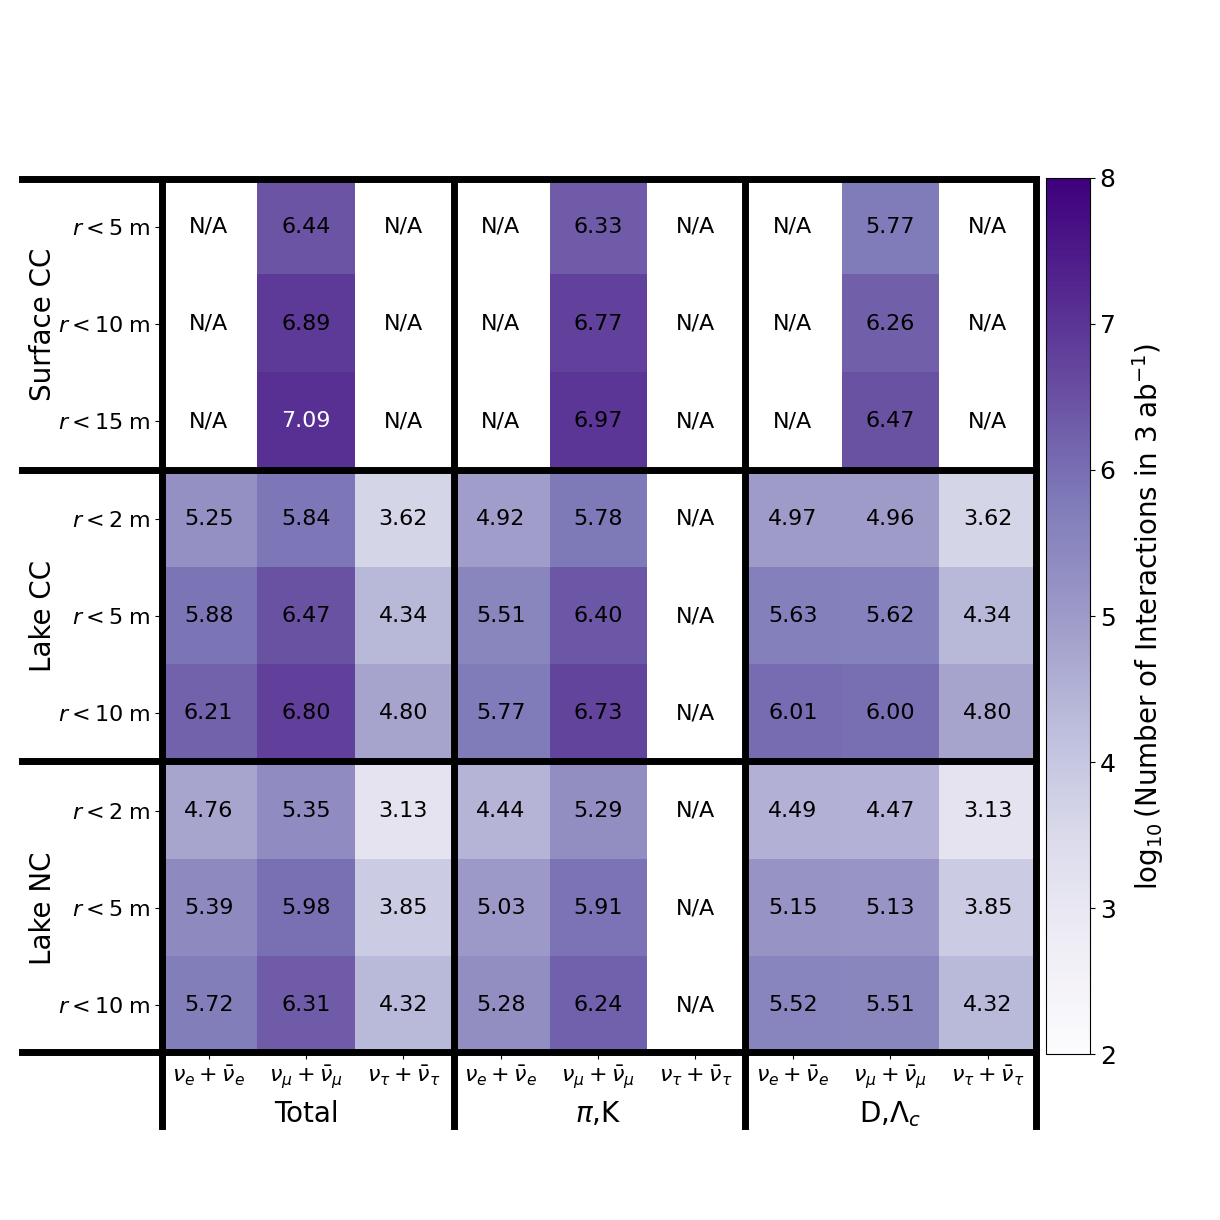

/tmp/ipykernel_723753/2032532268.py:117: RuntimeWarning: divide by zero encountered in log10
  if np.log10(total_rates_3x9[i,j])>6:


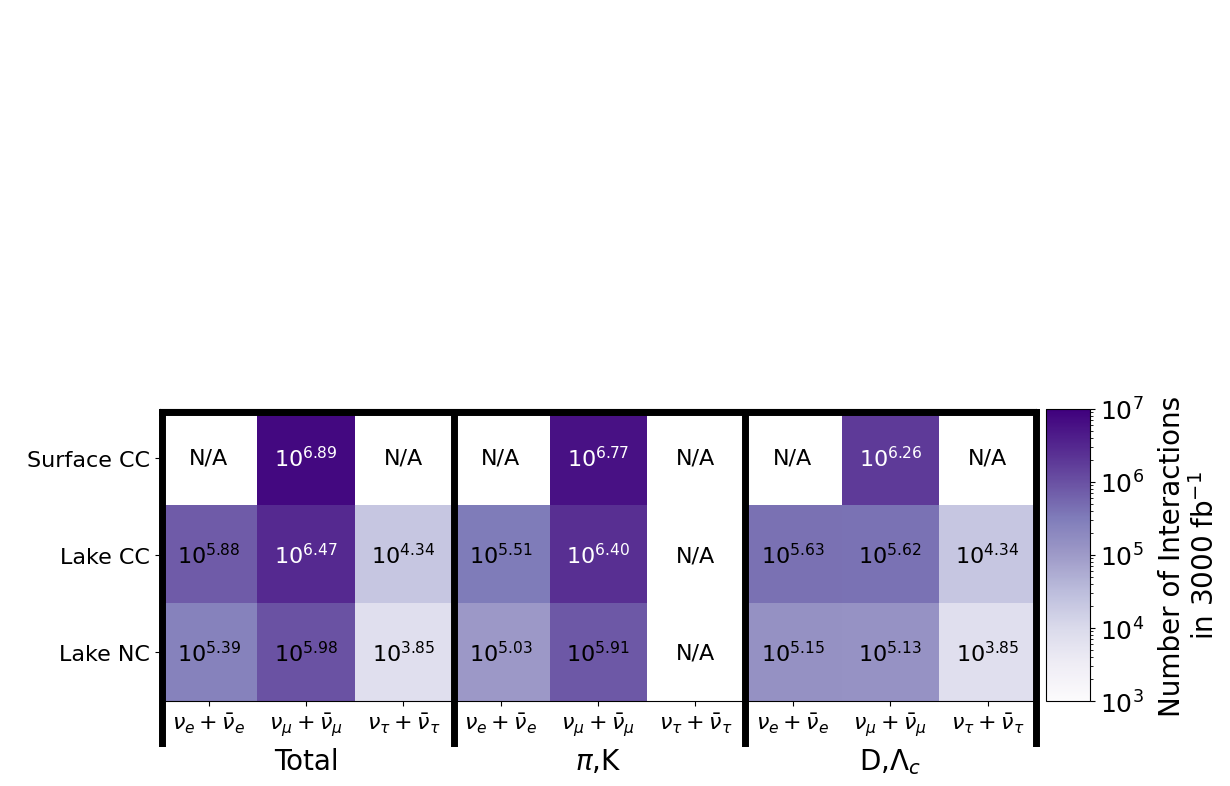

In [5]:
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable

xticklabels = []
for _ in range(3):
    for pl in particle_labels:
        xticklabels.append(pl)
yticklabels = []
for rates in [surface_fid_weights,lake_CC_fid_weights,lake_NC_fid_weights]:
    for (kl,kc),(fid_weights_l,fid_weights_c) in rates.items():
        if "EPOS" not in kl: continue
        for kcut in fid_weights_l.keys():
            yticklabels.append(r"$r < %d\;{\rm m}$"%kcut)
            
total_rates_average = np.array(list(total_rates_dict.values()),dtype=float)
total_rates_average = np.mean(total_rates_average,axis=0)

total_rates_dict["Average"] = total_rates_average
            
            
for k,total_rates in total_rates_dict.items():
    if k!= "Average": continue
    
    # 9x9 figure
    
    fig = plt.figure(figsize=(12,12))
    ax = plt.gca()
    fig.set_facecolor("white")
    im = ax.imshow(np.log10(total_rates),cmap='Purples',vmin=2,vmax=8)
        
    ax.set_xticks(range(9),xticklabels,fontsize=16)
    ax.set_yticks(range(9),yticklabels,fontsize=16)

    horizontal_pos = -1.7
    vertical_pos = 9.2
    ax.text(1,vertical_pos,"Total",fontsize=20,ha="center")
    ax.text(4,vertical_pos,r"$\pi$,K",fontsize=20,ha="center")
    ax.text(7,vertical_pos,r"D,$\Lambda_c$",fontsize=20,ha="center")
    for i,dl in enumerate(det_labels):
        ax.text(horizontal_pos,1+3*i,dl,fontsize=20,ha="center",va="center",rotation="vertical")

    for i in range(9):
        for j in range(9):
            textcolor="black"
            if np.log10(total_rates[i,j])>7:
                textcolor="white"
            if total_rates[i,j]<=0:
                ax.text(j,i,"N/A",ha="center",va="center",fontsize=16,color=textcolor)
            else:
                ax.text(j,i,"%1.2f"%np.log10(total_rates[i,j]),ha="center",va="center",fontsize=16,color=textcolor)


    ax2 = plt.axes([0,0,1,1], facecolor=(1,1,1,0))
    ax2.set_axis_off()

    ax2_xmin = 0.127
    ax2_xmax = 0.855
    ax2_ymax = 0.859
    ax2_ymin = 0.132

    ax2_xextent = ax2_xmax - ax2_xmin
    ax2_yextent = ax2_ymax - ax2_ymin

    ax2_ymin_low = 0.07
    ax2_xmin_low = 0.01

    lines = []
    for frac in [0,1,2,3]:
        frac/=3.
        lines += [
                  Line2D([ax2_xmin+frac*ax2_xextent,ax2_xmin+frac*ax2_xextent], [ax2_ymin_low,ax2_ymax], lw=5., color='black'),
                  Line2D([ax2_xmin_low,ax2_xmax], [ax2_ymin+frac*ax2_yextent,ax2_ymin+frac*ax2_yextent], lw=5., color='black')
                 ]
    for line in lines: ax2.add_line(line)

    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = plt.colorbar(im, cax=cax)
    cbar.ax.tick_params(labelsize=18)  # set your label size here
    cbar.set_label(r"$\log_{10} ($Number of Interactions in $3\;{\rm ab}^{-1})$",fontsize=20,labelpad=10)

    if type(k) == tuple:
        tag = "%s_%s"%(k[0],k[1])
    else:
        tag = k
    plt.gcf().patch.set_alpha(0.0)
    plt.savefig("Figures/Nu2024_Poster/RateMatrix_%s.pdf"%tag,dpi=100)
    plt.show()
    
    
    
    
    
    
    
    # 3 x 9 figure
    
    fig = plt.figure(figsize=(12,12))
    ax = fig.gca()
    fig.set_facecolor("white")
    total_rates_3x9 = total_rates[1:9:3,:]
    im = ax.imshow(total_rates_3x9,cmap='Purples',norm=LogNorm(vmin=1e3,vmax=1e7))
        
    ax.set_xticks(range(9),xticklabels,fontsize=16)
    ax.set_yticks(range(3),det_labels,fontsize=16)

    vertical_pos = 3.2
    ax.text(1,vertical_pos,"Total",fontsize=20,ha="center")
    ax.text(4,vertical_pos,r"$\pi$,K",fontsize=20,ha="center")
    ax.text(7,vertical_pos,r"D,$\Lambda_c$",fontsize=20,ha="center")

    for i in range(3):
        for j in range(9):
            textcolor="black"
            if np.log10(total_rates_3x9[i,j])>6:
                textcolor="white"
            if total_rates_3x9[i,j]<=0:
                ax.text(j,i,"N/A",ha="center",va="center",fontsize=16,color=textcolor)
            else:
                ax.text(j,i,r"$10^{%1.2f}$"%np.log10(total_rates_3x9[i,j]),ha="center",va="center",fontsize=16,color=textcolor)


    ax2 = plt.axes([0,0.335,1,0.615], facecolor=(1,1,1,0))
    ax2.set_axis_off()

    ax2_xmin = 0.127
    ax2_xmax = 0.855
    ax2_ymax = 0.454
    ax2_ymin = 0

    ax2_xextent = ax2_xmax - ax2_xmin
    ax2_yextent = ax2_ymax - ax2_ymin

    ax2_ymin_low = 0
    ax2_xmin_low = 0.01

    lines = []
    for frac in [0,1,2,3]:
        frac/=3.
        lines.append(Line2D([ax2_xmin+frac*ax2_xextent,ax2_xmin+frac*ax2_xextent], [ax2_ymin_low,ax2_ymax], lw=5., color='black'))
        if frac==1: lines.append(Line2D([ax2_xmin,ax2_xmax], [ax2_ymin+frac*ax2_yextent,ax2_ymin+frac*ax2_yextent], lw=5., color='black'))
    for line in lines: ax2.add_line(line)

    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = plt.colorbar(im, cax=cax)
    cbar.ax.tick_params(labelsize=18)  # set your label size here
    cbar.set_label("Number of Interactions\n" + r"in $3000\;{\rm fb}^{-1}$",fontsize=20,labelpad=10)

    if type(k) == tuple:
        tag = "%s_%s"%(k[0],k[1])
    else:
        tag = k
    plt.gcf().patch.set_alpha(0.0)
    plt.savefig("Figures/Nu2024_Poster/RateMatrix_%s_3x9.pdf"%tag,dpi=100)
    plt.show()
    
    
    
    
    
    


0.06788225099390857
('EPOSLHC', 'BKSS')
('DPMJET', 'BKRS')
('SIBYLL', 'SIBYLL')
('QGSJET', 'BDGJKR')
('PYTHIA8', 'MS')


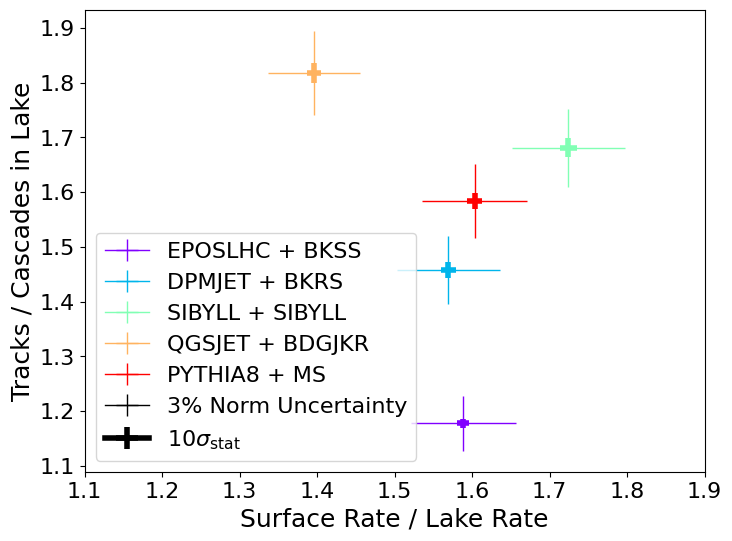

In [6]:
# tracks vs cascades measurement

norm_error = 0.03
print(1.6*np.sqrt(norm_error**2 + norm_error**2))
kcut_surface = 10
kcut_lake = 5
color = iter(cm.rainbow(np.linspace(0, 1, len(rates))))
for k in surface_fid_weights.keys():
    print(k)
    c = next(color)
    gen_l,gen_c = k
    light_simulation_surface = light_simulation_surface_dict[k]
    charm_simulation_surface = charm_simulation_surface_dict[k]
    light_simulation_lakeCC = light_simulation_lakeCC_dict[k]
    charm_simulation_lakeCC = charm_simulation_lakeCC_dict[k]
    light_simulation_lakeNC = light_simulation_lakeNC_dict[k]
    charm_simulation_lakeNC = charm_simulation_lakeNC_dict[k]
    
    fid_weights_surface_l,fid_weights_surface_c = surface_fid_weights[k]
    fid_weights_lakeCC_l, fid_weights_lakeCC_c = lake_CC_fid_weights[k]
    fid_weights_lakeNC_l, fid_weights_lakeNC_c = lake_NC_fid_weights[k]
    
    total_surface = exposure_factor*(sum(fid_weights_surface_l[kcut_surface]) + sum(fid_weights_surface_c[kcut_surface]))
    
    total_lake = exposure_factor*(sum(fid_weights_lakeCC_l[kcut_lake]) + \
                                  sum(fid_weights_lakeCC_c[kcut_lake]) + \
                                  sum(fid_weights_lakeNC_l[kcut_lake]) + \
                                  sum(fid_weights_lakeNC_c[kcut_lake])
                                 )
    
    numu_mask_l = abs(light_simulation_lakeCC.data["PDG"])==14
    numu_mask_c = abs(charm_simulation_lakeCC.data["PDG"])==14
    tracks_lake = exposure_factor * (sum(fid_weights_lakeCC_l[kcut_lake][numu_mask_l]) + sum(fid_weights_lakeCC_c[kcut_lake][numu_mask_c]))
    cascades_lake = exposure_factor * (sum(fid_weights_lakeCC_l[kcut_lake][np.logical_not(numu_mask_l)]) + \
                                       sum(fid_weights_lakeCC_c[kcut_lake][np.logical_not(numu_mask_c)]) + \
                                       sum(fid_weights_lakeNC_l[kcut_lake]) + \
                                       sum(fid_weights_lakeNC_c[kcut_lake])
                                      )

    r1 = total_surface / total_lake
    r2 = tracks_lake / cascades_lake
    r1_err = r1 * np.sqrt((norm_error*total_surface/total_surface)**2 + (norm_error*total_lake/total_lake)**2)
    r2_err = r2 * np.sqrt((norm_error*tracks_lake/tracks_lake)**2 + (norm_error*cascades_lake/cascades_lake)**2)
    r1_stat_err = r1 * np.sqrt(1/total_surface + 1/total_lake)
    r2_stat_err = r2 * np.sqrt(1/tracks_lake + 1/cascades_lake)
    plt.errorbar(r1,r2,xerr=r1_err,yerr=r2_err,color=c,lw=1,label="%s + %s"%(gen_l,gen_c))
    plt.errorbar(r1,r2,xerr=10*r1_stat_err,yerr=10*r2_stat_err,color=c,lw=4)
plt.errorbar([],[],xerr=[],yerr=[],color="black",lw=1,label="3% Norm Uncertainty")
plt.errorbar([],[],xerr=[],yerr=[],color="black",lw=4,label=r"$10 \sigma_{\rm stat}$")
plt.legend(loc="lower left")
plt.xlim(1.1,1.9)
plt.xlabel("Surface Rate / Lake Rate")
plt.ylabel("Tracks / Cascades in Lake")
plt.gcf().set_facecolor("white")
plt.gcf().patch.set_alpha(0.0)
plt.savefig("Figures/Nu2024_Poster/GeneratorDifferntiator.pdf",dpi=100)
plt.show()
    
    

('EPOSLHC', 'BKSS')


/n/home09/nkamp/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


('DPMJET', 'BKRS')
('SIBYLL', 'SIBYLL')
('QGSJET', 'BDGJKR')
('PYTHIA8', 'MS')


/tmp/ipykernel_4066109/350628325.py:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(UNDINERadius(xticks))


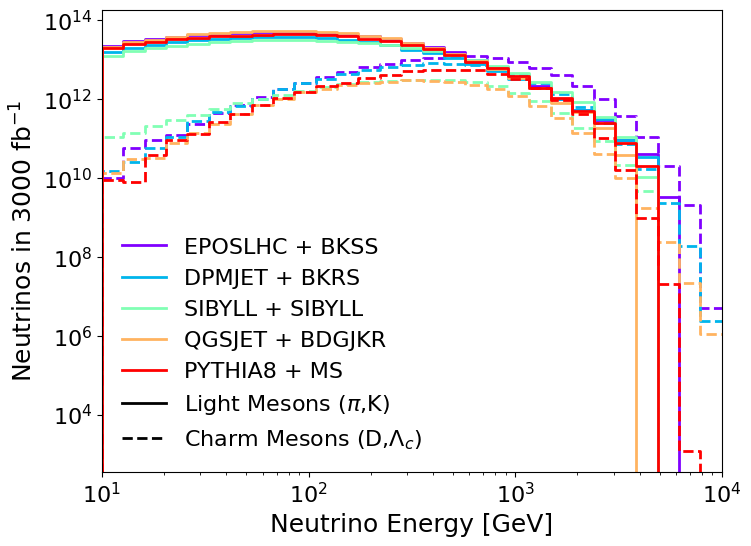

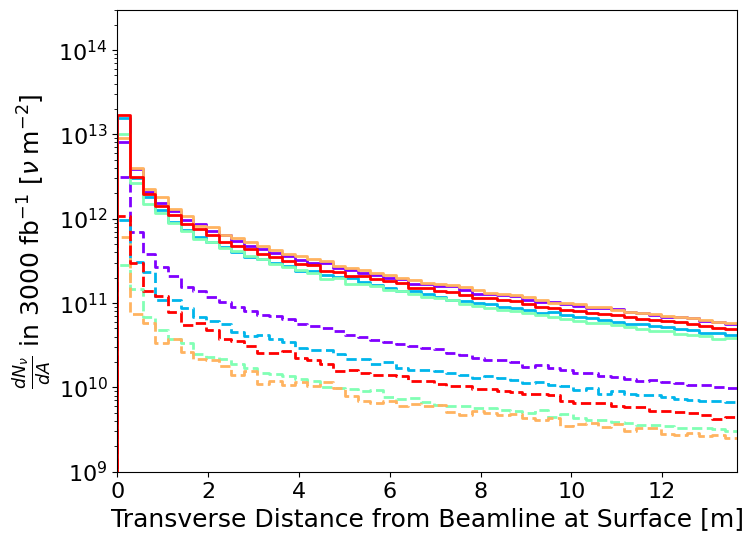

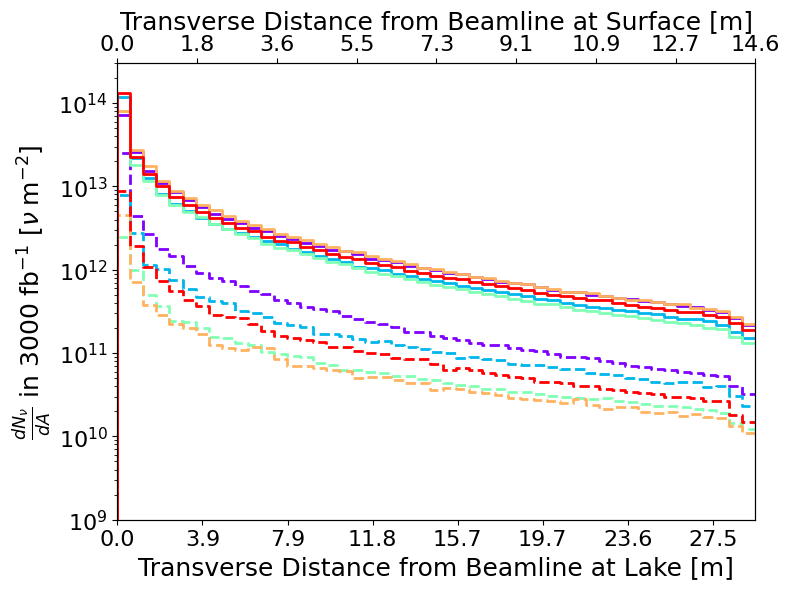

In [10]:
# Flux plots
from matplotlib.patches import Ellipse
figEnergy = plt.figure()
figProfileSurface = plt.figure()
figProfileLake = plt.figure()
color = iter(cm.rainbow(np.linspace(0, 1, len(surface_fid_weights))))
profile_bins_surface = np.linspace(0,7.5*(18210.36/10000),50)
profile_bins_lake = np.linspace(0,7.5,50)
for k in surface_fid_weights.keys():
    print(k)
    c = next(color)
    gen_l,gen_c = k
    light_simulation_surface = light_simulation_surface_dict[k]
    charm_simulation_surface = charm_simulation_surface_dict[k]
    light_simulation_lakeCC = light_simulation_lakeCC_dict[k]
    charm_simulation_lakeCC = charm_simulation_lakeCC_dict[k]
    
    light_rad_surface = np.sqrt(light_simulation_surface.data["nu_transverse_profile_x"]**2 + light_simulation_surface.data["nu_transverse_profile_y"]**2)
    charm_rad_surface = np.sqrt(charm_simulation_surface.data["nu_transverse_profile_x"]**2 + charm_simulation_surface.data["nu_transverse_profile_y"]**2)
    nlight,_ = np.histogram(light_rad_surface,weights=light_simulation_surface.data["wgt"]*1000*3000*(light_rad_surface**-2),bins=profile_bins_surface)
    ncharm,_ = np.histogram(charm_rad_surface,weights=charm_simulation_surface.data["wgt"]*1000*3000*(charm_rad_surface**-2),bins=profile_bins_surface)
    figProfileSurface.gca().step(profile_bins_surface,np.append(0,nlight),color=c,label="%s + %s"%(gen_l,gen_c))
    figProfileSurface.gca().step(profile_bins_surface,np.append(0,ncharm),linestyle="--",color=c)
    
    
    light_rad_lakeCC= np.sqrt(light_simulation_lakeCC.data["nu_transverse_profile_x"]**2 + light_simulation_lakeCC.data["nu_transverse_profile_y"]**2)
    charm_rad_lakeCC = np.sqrt(charm_simulation_lakeCC.data["nu_transverse_profile_x"]**2 + charm_simulation_lakeCC.data["nu_transverse_profile_y"]**2)
    nlight,_ = np.histogram(light_rad_lakeCC,weights=light_simulation_lakeCC.data["wgt"]*1000*3000*(light_rad_lakeCC**-2),bins=profile_bins_lake)
    ncharm,_ = np.histogram(charm_rad_lakeCC,weights=charm_simulation_lakeCC.data["wgt"]*1000*3000*(charm_rad_lakeCC**-2),bins=profile_bins_lake)
    figProfileLake.gca().step(profile_bins_lake,np.append(0,nlight),color=c,label="%s + %s"%(gen_l,gen_c))
    figProfileLake.gca().step(profile_bins_lake,np.append(0,ncharm),linestyle="--",color=c)
    
    light_rad_lakeCC= np.sqrt(light_simulation_lakeCC.data["muon_transverse_profile_x"]**2 + light_simulation_lakeCC.data["muon_transverse_profile_y"]**2)
    charm_rad_lakeCC = np.sqrt(charm_simulation_lakeCC.data["muon_transverse_profile_x"]**2 + charm_simulation_lakeCC.data["muon_transverse_profile_y"]**2)
    nlight,_ = np.histogram(light_rad_lakeCC,weights=light_simulation_lakeCC.data["wgt"]*1000*3000*(light_rad_lakeCC**-2),bins=profile_bins_lake)
    ncharm,_ = np.histogram(charm_rad_lakeCC,weights=charm_simulation_lakeCC.data["wgt"]*1000*3000*(charm_rad_lakeCC**-2),bins=profile_bins_lake)
    figProfileLake.gca().step(profile_bins_lake,np.append(0,nlight),color=c,label="%s + %s"%(gen_l,gen_c))
    figProfileLake.gca().step(profile_bins_lake,np.append(0,ncharm),linestyle="--",color=c)
    
    nlight,_ = np.histogram(light_simulation_surface.data["E"],bins=Ebins,weights=light_simulation_surface.data["wgt"]*1000*3000)
    ncharm,_ = np.histogram(charm_simulation_surface.data["E"],bins=Ebins,weights=charm_simulation_surface.data["wgt"]*1000*3000)
    figEnergy.gca().step(Ebins,np.append(0,nlight),color=c,label="%s + %s"%(gen_l,gen_c))
    figEnergy.gca().step(Ebins,np.append(0,ncharm),color=c,linestyle="--")
    

figProfileSurface.gca().semilogy()
figProfileSurface.gca().set_ylim(1e9,3e14)
figProfileSurface.gca().set_xlim(profile_bins_surface[0],profile_bins_surface[-1])
figProfileSurface.gca().plot([],[],color="black",label=r"Light Mesons ($\pi$,K)")
figProfileSurface.gca().plot([],[],color="black",ls='--',label=r"Charm Mesons (D,$\Lambda_c$)")
figProfileSurface.gca().set_xlabel(r"Transverse Distance from Beamline at Surface [m]")
figProfileSurface.gca().set_ylabel(r"$\frac{dN_\nu}{dA}$ in 3000 ${\rm fb}^{-1}$ $[\nu\;{\rm m}^{-2}]$")
figProfileSurface.set_facecolor("white")
figProfileSurface.patch.set_alpha(0.0)
figProfileSurface.savefig("Figures/Nu2024_Poster/FluxProfileSurface.pdf")

figProfileLake.gca().semilogy()
figProfileLake.gca().set_ylim(1e9,3e14)
figProfileLake.gca().set_xlim(profile_bins_lake[0],profile_bins_lake[-1])
figProfileLake.gca().plot([],[],color="black",label=r"Light Mesons ($\pi$,K)")
figProfileLake.gca().plot([],[],color="black",ls='--',label=r"Charm Mesons (D,$\Lambda_c$)")
figProfileLake.gca().set_xlabel(r"Transverse Distance from Beamline at Lake [m]")
figProfileLake.gca().set_ylabel(r"$\frac{dN_\nu}{dA}$ in 3000 ${\rm fb}^{-1}$ $[\nu\;{\rm m}^{-2}]$")
figProfileLake.set_facecolor("white")
figProfileLake.patch.set_alpha(0.0)
ax1 = figProfileLake.gca()
xticks = ax1.get_xticks()
ax2 = figProfileLake.gca().twiny()
def SINERadius(X):
    V = (18210.36/10000)*X
    return ["%1.1f" % z for z in V]
def UNDINERadius(X):
    V = (39312/10000)*X
    return ["%1.1f" % z for z in V]
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(xticks)
ax2.set_xticklabels(SINERadius(xticks))
ax1.set_xticklabels(UNDINERadius(xticks))
ax2.set_xlabel("Transverse Distance from Beamline at Surface [m]")
plt.tight_layout()
figProfileLake.savefig("Figures/Nu2024_Poster/FluxProfileLake.pdf",dpi=100)

figEnergy.gca().loglog()
#figEnergy.gca().set_ylim(1e8,3e12)
figEnergy.gca().set_xlim(Ebins[0],Ebins[-1])
figEnergy.gca().plot([],[],color="black",label=r"Light Mesons ($\pi$,K)")
figEnergy.gca().plot([],[],color="black",ls='--',label=r"Charm Mesons (D,$\Lambda_c$)")
figEnergy.gca().legend()
figEnergy.gca().set_xlabel(r"Neutrino Energy [GeV]")
figEnergy.gca().set_ylabel(r"Neutrinos in 3000 ${\rm fb}^{-1}$")
figEnergy.set_facecolor("white")
figEnergy.patch.set_alpha(0.0)
figEnergy.savefig("Figures/Nu2024_Poster/FluxEnergy.pdf",dpi=100)

plt.show()

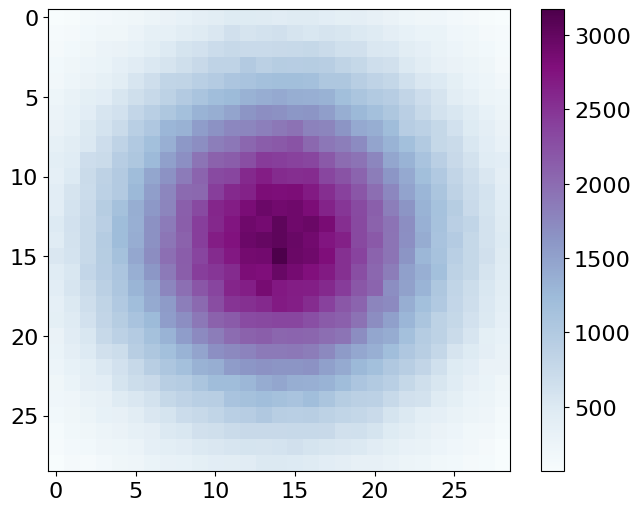

std(x)= 1.0006819442113937
std(y)= 0.9994936595963891
(29, 29)
1.0000882079444782
[781.6550154525344, 1563.3100309050687, 2344.965046357603]


/tmp/ipykernel_723753/2036202286.py:45: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  lines = [ cs.collections[0]]


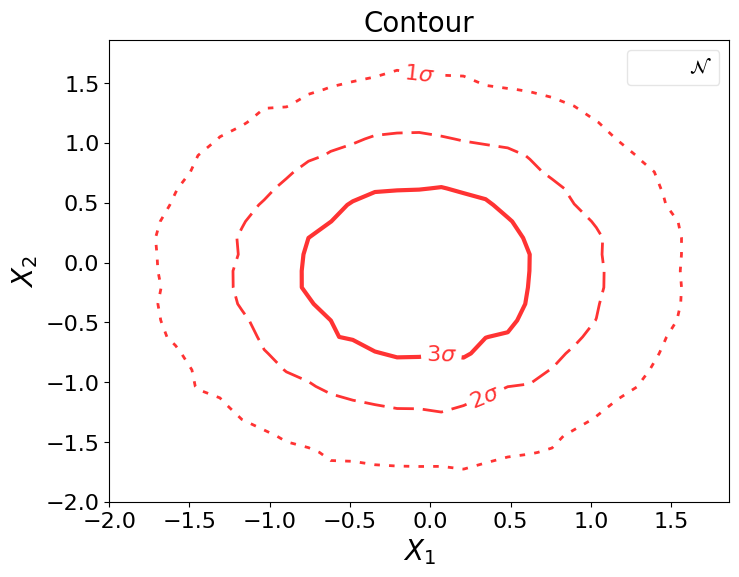

In [8]:
x, y = np.random.normal(size=(2, 1000000))

xbins = np.linspace(-2, 2, 30)
ybins = np.linspace(-2, 2, 30)

counts, xedges, yedges = np.histogram2d(x, y, bins=(xbins, ybins))

plt.imshow(counts)
plt.colorbar()
plt.show()

print("std(x)=", np.std(x))
print("std(y)=", np.std(y))

# Plot data #################

fig, ax = plt.subplots()

sigmas = [1., 2., 3.]
levels = []
fmt = {}

print(counts.shape)
print(np.std((x,y)))

for sigma in sigmas:
    levels.append(float(sigma) * np.std(counts))
    fmt[float(sigma) * np.std(counts)] = r"${}\sigma$".format(int(sigma))
    
print(levels)

cs = plt.contour(xedges[:-1], yedges[:-1], counts.T, levels,
                  linewidths=(2, 2, 3), linestyles=('dotted', 'dashed', 'solid'),
                  alpha=0.8, colors='red')
ax.clabel(cs, inline=True, fontsize=16, fmt=fmt)

# Set title and labels ######

ax.set_title("Contour", fontsize=20)
ax.set_xlabel(r"$X_1$", fontsize=20)
ax.set_ylabel(r"$X_2$", fontsize=20)

# Set legend ################

lines = [ cs.collections[0]]
labels = [r'$\mathcal{N}$']
ax.legend(lines, labels, prop={'size': 14}, loc='best', fancybox=True, framealpha=0.5)

# Save file #################

plt.savefig("contour_from_hist2d_sigmas.png")

# Plot ######################

plt.show()